In [1]:
# Regression model algorithm to predict quantity of sales based on price, date, promotions and marketing investing.
# At the end, we will be able to predict the demand of a future promotion and schedule the purchase and distribution of products.

# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication
import smtplib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

data = datetime.today().date()
data_hoje = str(data)


project = 'maga-bigdata' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [2]:
query =  """

WITH

HIST AS (
  SELECT DISTINCT
  CD,
  IBM,
  DATA_INICIO,
  DATA_FIM,
  CATEGORIA,
  EMISSORA,
  FROM `maga-bigdata.supply_intelligence.farol_promo_hist`
  WHERE EXTRACT(YEAR FROM `maga-bigdata.supply_intelligence.farol_promo_hist`.DATA_INICIO) > 2020
),

PRODUTO AS (
  SELECT DISTINCT
      B.CODITPROD
    , B.CODITPROD||B.DIGITPROD                          AS GEMCO
    , B.CODPRODDF                                       AS IBM
    , B.DESCPROD                                        AS DESCRICAO
    , B.CODSITPROD                                      AS SITUACAO_PRODUTO
    , B.CODLINHA
    , B.DESCLINHA                                       AS LINHA
    , B.CODFAM
    , B.DESCFAM                                         AS FAMILIA
    , TRIM(SUBSTRING(B.DESCLINHA, 1, 3))                AS CATEGORIA
    , D.DIRETORIA
    , N.NUCLEO
    , IFNULL(C.STATUS, '-')                             AS CLASS_ABCDZ
    , E.ID_AGRUP                                        AS ID_FORNECEDOR
    , E.NOME_AGRUP                                      AS FORNECEDOR
      --, COUNT(CODITPROD) AS COUNT

  FROM `maga-bigdata.mlpdw.mag_t_arvore_produto` AS B

  LEFT JOIN
    (SELECT STATUS
            , IBM
            , VMD

    FROM `maga-bigdata.advanced_analytics.status_final_produtos_CDs`

    WHERE DATE(DATA) = (SELECT MAX(DATE(DATA)) FROM `maga-bigdata.advanced_analytics.status_final_produtos_CDs` )) C
          ON CAST(B.CODPRODDF AS INT64) = CAST(C.IBM AS INT64)

  LEFT JOIN
    `maga-bigdata.controladoria.mag_t_cad_agrup_fornecedor` E
        ON B.CODFORNE = E.CODIGO_FORNE

  LEFT JOIN `maga-bigdata.advanced_analytics.demand_depara_nucleo` N
        ON TRIM(SUBSTRING(B.DESCLINHA, 1, 3)) = N.category

  LEFT JOIN `maga-bigdata.advanced_analytics.demand_depara_diretoria` D
        ON TRIM(SUBSTRING(B.DESCLINHA, 1, 3)) = D.category

  WHERE B.DESCLINHA NOT LIKE ('%- PE')

  ORDER BY CODITPROD
),


CDDIMENSION AS (
  SELECT
    CDId
    , CD
    , State                         AS ESTADO
    , Region                        AS REGIAO
    , CASE
        WHEN CD IN (50,94,400,490,550,994,1100,1250,1500,1800,2000,2100,2650,2750,5200,5350)
        THEN 'REGIONAL'
        WHEN CD IN (300,350,590,991,2300,2500,2900,5500)
        THEN 'MALHA'
        WHEN CD IN (997,2400)
        THEN 'CROSS'
        ELSE 'OUTROS'
      END                            AS TIPO_CD

  FROM `maga-bigdata.abastecimento.cddimension`

  WHERE CAST(CD AS INT64) NOT IN (6001, 2800, 1700, 996, 995, 650, 95)
),


BRANCHDIMENSION AS (
  SELECT
    CD.CD                               AS CD
    , F.BranchId                        AS FILIAL
    , F.Active                          AS ACTIVE

  FROM CDDIMENSION CD

  LEFT JOIN `maga-bigdata.abastecimento.branchdimension` F
            ON CD.CDId = F.CdId

  WHERE
    F.InaugurationDate <= CURRENT_DATE()
    AND F.Active = 1
),


TRONCO_COMUM_GEMEO AS (
  SELECT DISTINCT
          A.DATA_ATUAL
          , A.IBM
          , A.GEMEO
          , A.CATEGORIACOMERCIAL
          , A.TRONCO_COMUM
          , A.TRONCO_COMUM_GEMEO

  FROM `advanced_analytics.indicador_ruptura_historico` A

  WHERE TRONCO_COMUM_GEMEO = 1
),


CONTAGEM_ITENS_GEMEO AS (
  SELECT DISTINCT
          A.DATA_ATUAL
          , A.GEMEO
          , COUNT(DISTINCT IBM) AS CONTAGEM_GEMEO

  FROM `advanced_analytics.indicador_ruptura_historico` A

  WHERE TRONCO_COMUM_GEMEO = 1

  GROUP BY 1, 2
),


ELEGIBILIDADE AS (
  SELECT DISTINCT
          DATE_TRUNC(DATE(DATA_ATUAL), MONTH) AS DATA_BASE
          , CATEGORIACOMERCIAL
          , '1' AS FLAG_ELEGIBILIDADE

  FROM `advanced_analytics.indicador_ruptura_historico`

  WHERE TRONCO_COMUM_GEMEO = 1
),


SORTIMENTO_ABA AS (
  SELECT DISTINCT
          DATE_TRUNC(DATE(DATA_ATUAL), MONTH) AS DATA_BASE
          , CD
          , IBM
          , GEMEO
          , SORT_ABA

  FROM `advanced_analytics.indicador_ruptura_historico`

  WHERE SORT_ABA = 1

  ORDER BY 3, 1, 2
),
BASE AS (SELECT a.ANO_MES,
       a.CATEGORIA,
       a.LINHA,
       a.FAMILIA,
       a.CODIGO_IBM             AS IBM,
       a.CODITPROD||a.DIGITPROD AS GEMCO,
       a.DESCRICAO,
       a.FILIAL_VENDA,
       a.FILIAL_SAIDA,
       F.CODCDLOJA              AS CD_FILIAL_SAIDA,
       a.FILIAL_ENTREGA,
       CASE
          WHEN a.FILIAL_VENDA NOT IN (200)
          THEN 'REDE'
          WHEN a.FILIAL_VENDA IN (200) AND a.FILIAL_SAIDA IN (SELECT DISTINCT FILIAL FROM BRANCHDIMENSION)
          THEN 'ECOM'
          WHEN a.FILIAL_VENDA IN (200) AND a.FILIAL_SAIDA IN (SELECT DISTINCT CD FROM CDDIMENSION)
          THEN 'SITE'
          ELSE 'NA'
       END AS TIPO_VENDA,
       SUM(VENDA_QTDE)          AS VENDA_QTDE,
       SUM(PRECO)         AS PRECO

FROM (

      SELECT  v2.data_nf AS ANO_MES,
              IFNULL(fam.categoriacomercial,'TM') AS CATEGORIA,
              prod.CODLINHA AS CODIGO_LINHA,
              lin.LINHA,
              prod.CODFAM AS CODIGO_FAMILIA,
              fam.FAMILIA,
              v2.produto_ibm AS CODIGO_IBM,
              prod.coditprod AS CODITPROD,
              prod.digitprod AS DIGITPROD,
              pr.descricao AS DESCRICAO,
              v2.filial_venda,
              v2.filial_saida,
              v2.filial_entrega,
              'Venda' AS TIPO,
              CAST(SUM(IFNULL(v2.quantidade,0)) AS FLOAT64) AS VENDA_QTDE,
              CAST(SUM(IFNULL(v2.quantidade,0) * IFNULL(v2.VALOR_UNITARIO_NF,0)) AS FLOAT64) AS PRECO

      FROM (

            SELECT  v.*, 1 AS qtd_pedidos,
                    COUNT(v.numero_nf) OVER (PARTITION BY v.numero_nf, v.data_nf, v.filial_emissao_nf) qtd_ped_tt

            FROM controladoria.mag_v_notafiscal_venda_nova v

            WHERE date(v.data_nf) >= DATE_SUB(CURRENT_DATE(), INTERVAL 600 DAY)  ------------------------------------------- DETERMINA PERÍODO DA CONSULTA
                   ) v2
      LEFT JOIN mlpbi.mag_t_dim_filial        fil
          ON v2.filial_venda = fil.filialkey
      LEFT JOIN balboa.cad_itprod             prod
          ON v2.produto_ibm = prod.codproddf
      LEFT JOIN mlpbi.mag_t_dim_linha         lin
          ON prod.codlinha = lin.linhakey
      LEFT JOIN mlpbi.mag_t_dim_familia       fam
          ON prod.codfam = fam.familiakey
      LEFT JOIN balboa.cad_prod               pr
          ON prod.codprod = pr.codprod

      GROUP BY  v2.data_nf,
                IFNULL(fam.categoriacomercial,'TM'),
                prod.CODLINHA,
                lin.LINHA,
                prod.CODFAM,
                fam.FAMILIA,
                v2.produto_ibm,
                prod.coditprod,
                prod.digitprod,
                pr.descricao,
                v2.filial_venda,
                v2.filial_saida,
                v2.filial_entrega


      UNION ALL


      SELECT v2.data_conferencia as ANO_MES,
             IFNULL(fam.categoriacomercial,'TM') as CATEGORIA,
             prod.codlinha as CODIGO_LINHA,
             lin.linha,
             prod.codfam as CODIGO_FAMILIA,
             fam.familia,
             v2.produto_ibm as CODIGO_IBM,
             prod.coditprod AS CODITPROD,
              prod.digitprod AS DIGITPROD,
             pr.descricao AS DESCRICAO,
             v2.filial_venda,
             v2.filial_NFsaida as FILIAL_SAIDA,
             v2.filial_emissao_nf as FILIAL_ENTREGA,
             'Devol' as TIPO,
             CAST(-SUM(IFNULL(v2.quantidade,0)) AS FLOAT64) as VENDA_QTDE,
             CAST(-SUM(IFNULL(v2.quantidade,0) * IFNULL(v2.VALOR_UNITARIO_NF,0)) AS FLOAT64) as PRECO

      FROM (

            SELECT  d.*, 1 as qtd_pedidos,
                    COUNT(d.numero_nf) OVER (PARTITION BY d.numero_nf, d.data_conferencia, d.filial_emissao_nf) qtd_ped_tt

            FROM controladoria.mag_v_notafiscal_devvenda_nova d

            WHERE date(d.data_conferencia) >=DATE_SUB(CURRENT_DATE(), INTERVAL 600 DAY)  ) v2 ------------------------------------------- DETERMINA PERÍODO DA CONSULTA

      LEFT JOIN mlpbi.mag_t_dim_filial          fil
          ON v2.filial_venda = fil.filialkey
      LEFT JOIN balboa.cad_itprod               prod
          ON v2.produto_ibm = prod.codproddf
      LEFT JOIN mlpbi.mag_t_dim_linha           lin
          ON prod.codlinha = lin.linhakey
      LEFT JOIN mlpbi.mag_t_dim_familia         fam
          ON prod.codfam = fam.familiakey
      LEFT JOIN balboa.cad_prod                 pr
          ON prod.codprod = pr.codprod


      GROUP BY v2.data_conferencia,
            IFNULL(fam.categoriacomercial,'TM'),
            prod.codlinha,
            lin.linha,
            prod.codfam,
            fam.familia,
            prod.coditprod,
            prod.digitprod,
            pr.descricao,
            v2.produto_ibm,
            v2.filial_venda,
            v2.filial_NFsaida,
            v2.filial_emissao_nf ) a

LEFT JOIN `maga-bigdata.dw.VW_DIM_FILIAL` F
    ON a.FILIAL_SAIDA = F.FILIALKEY

GROUP BY a.ANO_MES,
         a.CATEGORIA,
         a.CODIGO_LINHA,
         a.LINHA,
         a.CODIGO_FAMILIA,
         a.FAMILIA,
         a.CODIGO_IBM,
         a.CODITPROD||a.DIGITPROD,
         a.CODITPROD,
         a.DIGITPROD,
         a.DESCRICAO,
         a.FILIAL_VENDA,
         a.FILIAL_SAIDA,
         F.CODCDLOJA,
         a.FILIAL_ENTREGA,
         TIPO_VENDA

)

SELECT

BASE.IBM,
BASE.DESCRICAO,
SUM(VENDA_QTDE) AS QUANTIDADE,
ROUND(PRECO, 0) AS PRECO,
UPPER(EMISSORA) AS EMISSORA,
CASE EXTRACT(DAYOFWEEK FROM BASE.ANO_MES)
    WHEN 1 THEN 'Domingo'
    WHEN 2 THEN 'Segunda-feira'
    WHEN 3 THEN 'Terça-feira'
    WHEN 4 THEN 'Quarta-feira'
    WHEN 5 THEN 'Quinta-feira'
    WHEN 6 THEN 'Sexta-feira'
    WHEN 7 THEN 'Sábado'
  END AS DIA_SEMANA,
DATE_DIFF(BASE.ANO_MES, DATE_SUB(DATE_TRUNC(BASE.ANO_MES, MONTH), INTERVAL 1 DAY), WEEK) AS SEMANA,
EXTRACT(MONTH FROM BASE.ANO_MES) AS MES,
EXTRACT(YEAR FROM BASE.ANO_MES) AS ANO,

FROM BASE

LEFT JOIN HIST ON
CAST(BASE.IBM AS INT64) = HIST.IBM AND
BASE.ANO_MES >= HIST.DATA_INICIO AND
BASE.ANO_MES <= HIST.DATA_FIM AND
BASE.CD_FILIAL_SAIDA = HIST.CD

LEFT JOIN `maga-bigdata.advanced_analytics.demand_depara_diretoria`
ON BASE.CATEGORIA = `maga-bigdata.advanced_analytics.demand_depara_diretoria`.CATEGORY

WHERE VENDA_QTDE > 0 AND TIPO_VENDA = "REDE" AND BASE.IBM = "144134600"

GROUP BY EMISSORA, DIA_SEMANA, SEMANA, MES, ANO, IBM, DESCRICAO, PRECO

"""

In [3]:
query_job_agendas = client.query(query)
results = query_job_agendas.result()

In [4]:
column_names = [field.name for field in results.schema]

In [5]:
filename = "hist.csv"
with open(filename, "w") as f:
  f.write(";".join(column_names) + "\n")

  for row in results:
    f.write(";".join([str(row[field.name]) for field in results.schema]) + "\n")

In [6]:
df = pd.read_csv(filename, sep=";")

In [7]:
valores_substitutos = {'EMISSORA': 'DIA_NORMAL'}
df = df.fillna(valores_substitutos)

df['EMISSORA'] = df['EMISSORA'].replace("None", "DIA_NORMAL")

In [8]:
df['SEMANA'] = df['SEMANA'].replace(0, 1)
df['SEMANA'] = df['SEMANA'].replace(5, 4)

In [9]:
def remove_outliers(df, col_produto, col_preco, lower_threshold=1.0, upper_threshold=1.0):
    df['media_preco'] = df.groupby(col_produto)[col_preco].transform('mean')
    df['desvio_padrao_preco'] = df.groupby(col_produto)[col_preco].transform('std')

    df['z_score'] = (df[col_preco] - df['media_preco']) / df['desvio_padrao_preco']

    df_filtered = df[(df['z_score'] >= -lower_threshold) & (df['z_score'] <= upper_threshold)]

    df_filtered.drop(['media_preco', 'desvio_padrao_preco', 'z_score', 'IBM'], axis=1, inplace=True)

    return df_filtered

df = remove_outliers(df, 'IBM', 'PRECO', lower_threshold=0.8, upper_threshold=0.001)

valor_moda = df['DESCRICAO'].mode()[0]
df['DESCRICAO'] = valor_moda


<ipython-input-9-12a1d1a0235e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(['media_preco', 'desvio_padrao_preco', 'z_score', 'IBM'], axis=1, inplace=True)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6645 entries, 1 to 10602
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DESCRICAO   6645 non-null   object 
 1   QUANTIDADE  6645 non-null   float64
 2   PRECO       6645 non-null   float64
 3   EMISSORA    6645 non-null   object 
 4   DIA_SEMANA  6645 non-null   object 
 5   SEMANA      6645 non-null   int64  
 6   MES         6645 non-null   int64  
 7   ANO         6645 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 467.2+ KB


In [11]:
df.to_excel('hist_tratado.xlsx', index=False)

In [12]:
# Calcular o valor mínimo da coluna 'preco'
valor_minimo = df['PRECO'].min()

# Calcular o valor máximo da coluna 'preco'
valor_maximo = df['PRECO'].max()

# Calcular o valor médio da coluna 'preco'
valor_medio = df['PRECO'].mean()

# Exibir os resultados
print("Valor Mínimo da coluna 'PRECO':", valor_minimo)
print("Valor Máximo da coluna 'PRECO':", valor_maximo)
print("Valor Médio da coluna 'PRECO':", valor_medio)

Valor Mínimo da coluna 'PRECO': 429.0
Valor Máximo da coluna 'PRECO': 1086.0
Valor Médio da coluna 'PRECO': 683.7522949586155


In [13]:
valor_maximo = df['QUANTIDADE'].max()

valor_medio = df['QUANTIDADE'].mean()

print("Valor Máximo da coluna 'QUANTIDADE':", valor_maximo)
print("Valor Médio da coluna QUANTIDADE':", valor_medio)

Valor Máximo da coluna 'QUANTIDADE': 444.0
Valor Médio da coluna QUANTIDADE': 4.663054928517682


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'DIA_NORMAL'),
  Text(1, 0, 'GLOBO'),
  Text(2, 0, 'INTERNO'),
  Text(3, 0, 'LAMINA'),
  Text(4, 0, 'MALA'),
  Text(5, 0, 'MÍDIA NET')])

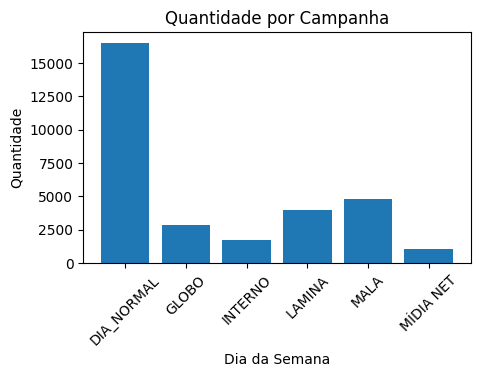

In [14]:
agrupado_emissora = df.groupby('EMISSORA')['QUANTIDADE'].sum().reset_index()

plt.figure(figsize=(5, 3))  # Ajuste o tamanho do gráfico conforme necessário
plt.bar(agrupado_emissora['EMISSORA'], agrupado_emissora['QUANTIDADE'])
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade')
plt.title('Quantidade por Campanha')
plt.xticks(rotation=45)

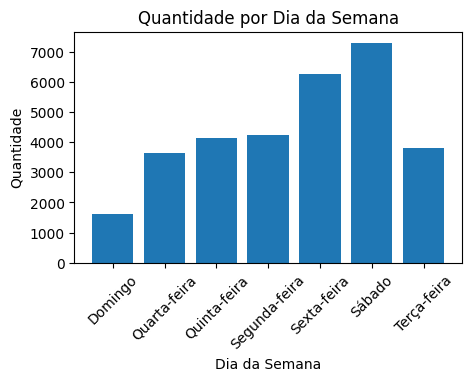

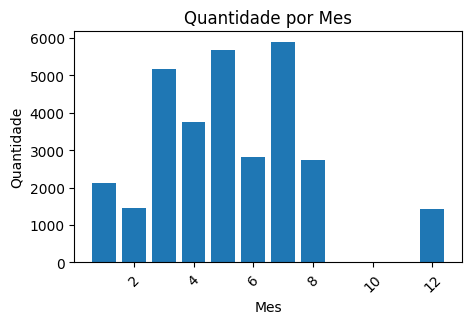

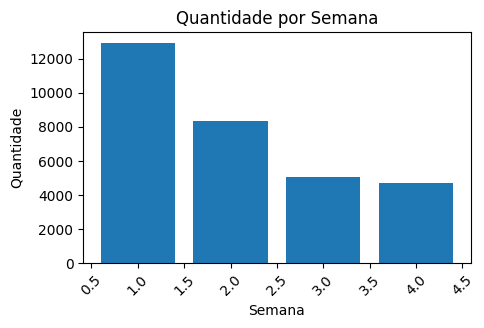

In [15]:
agrupado = df.groupby('DIA_SEMANA')['QUANTIDADE'].sum().reset_index()

plt.figure(figsize=(5, 3))  # Ajuste o tamanho do gráfico conforme necessário
plt.bar(agrupado['DIA_SEMANA'], agrupado['QUANTIDADE'])
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade')
plt.title('Quantidade por Dia da Semana')
plt.xticks(rotation=45)

agrupado_mes = df.groupby('MES')['QUANTIDADE'].sum().reset_index()
plt.figure(figsize=(5, 3))  # Ajuste o tamanho do gráfico conforme necessário
plt.bar(agrupado_mes['MES'], agrupado_mes['QUANTIDADE'])
plt.xlabel('Mes')
plt.ylabel('Quantidade')
plt.title('Quantidade por Mes')
plt.xticks(rotation=45)

agrupado_semana = df.groupby('SEMANA')['QUANTIDADE'].sum().reset_index()
plt.figure(figsize=(5, 3))  # Ajuste o tamanho do gráfico conforme necessário
plt.bar(agrupado_semana['SEMANA'], agrupado_semana['QUANTIDADE'])
plt.xlabel('Semana')
plt.ylabel('Quantidade')
plt.title('Quantidade por Semana')
plt.xticks(rotation=45)

plt.show()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6645 entries, 1 to 10602
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DESCRICAO   6645 non-null   object 
 1   QUANTIDADE  6645 non-null   float64
 2   PRECO       6645 non-null   float64
 3   EMISSORA    6645 non-null   object 
 4   DIA_SEMANA  6645 non-null   object 
 5   SEMANA      6645 non-null   int64  
 6   MES         6645 non-null   int64  
 7   ANO         6645 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 467.2+ KB


In [17]:
df.head()

,DESCRICAO,QUANTIDADE,PRECO,EMISSORA,DIA_SEMANA,SEMANA,MES,ANO
1,CJ PANELAS BRINOX OPTIMA VANILLA 5 PCS,155.0,500.0,DIA_NORMAL,Sexta-feira,1,1,2023
2,CJ PANELAS BRINOX OPTIMA VANILLA 5 PCS,24.0,1000.0,DIA_NORMAL,Sábado,1,1,2023
4,CJ PANELAS BRINOX OPTIMA VANILLA 5 PCS,2.0,1046.0,DIA_NORMAL,Quinta-feira,1,1,2023
5,CJ PANELAS BRINOX OPTIMA VANILLA 5 PCS,15.0,500.0,DIA_NORMAL,Terça-feira,2,1,2023
6,CJ PANELAS BRINOX OPTIMA VANILLA 5 PCS,110.0,500.0,DIA_NORMAL,Sábado,1,1,2023


In [18]:
colunas_categoricas = ['SEMANA', 'MES', 'ANO', 'DIA_SEMANA', 'EMISSORA']

df_dummies = pd.DataFrame()

for col in colunas_categoricas:
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=False)
    df_dummies = pd.concat([df_dummies, dummies], axis=1)

df = pd.concat([df, df_dummies], axis=1)

In [19]:
X = df.drop(['QUANTIDADE', 'DESCRICAO', 'DIA_SEMANA', 'SEMANA', 'MES', 'ANO', 'EMISSORA'], axis=1)
y = df['QUANTIDADE']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [21]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

In [22]:
for i in range(len(y_pred)):
    if y_pred[i] < 1:
        y_pred[i] = 1

In [23]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Erro Médio Quadrático (MSE): {mse}')
print(f'Coeficiente de Determinação (R²): {r2}')

Erro Médio Quadrático (MSE): 380.62694147801454
Coeficiente de Determinação (R²): 0.02148524303957211


In [24]:
df_resultados = pd.DataFrame({'Real': y_test, 'Previsao': y_pred})

df_resultados.to_excel('resultados_regressao.xlsx', index=False)